In [ ]:
!pip install nibabel
!pip install torch torchvision
!pip install monai
!pip install --upgrade monai
!pip install nibabel matplotlib torch torchvision
! pip install torch torchvision segmentation-models-pytorch nibabel

In [ ]:
from google.cloud import storage

client = storage.Client()

bucket_name = 'marketplace-p115jwl6'
dataset_path = 'Medical Decathlon Spleen/148/'

bucket = client.get_bucket(bucket_name)

blobs = bucket.list_blobs(prefix=dataset_path)

for blob in blobs:
    print(blob.name)


In [ ]:
import os
from google.cloud import storage

client = storage.Client()

bucket_name = 'marketplace-p115jwl6'
train_image_path = 'Medical Decathlon Spleen/148/artifactFiles/imagesTr/'
test_image_path = 'Medical Decathlon Spleen/148/artifactFiles/imagesTs/'
label_path = 'Medical Decathlon Spleen/148/artifactFiles/labelsTr/'

train_dir = './train'
test_dir = './test'
label_dir = './train/labels'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

def download_blob_to_directory(bucket_name, source_blob_name, destination_dir):
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    destination_file_name = os.path.join(destination_dir, os.path.basename(source_blob_name))
    print(f"Downloading {source_blob_name} to {destination_file_name}")
    blob.download_to_filename(destination_file_name)

train_blobs = client.list_blobs(bucket_name, prefix=train_image_path)
for blob in train_blobs:
    download_blob_to_directory(bucket_name, blob.name, train_dir)

label_blobs = client.list_blobs(bucket_name, prefix=label_path)
for blob in label_blobs:
    download_blob_to_directory(bucket_name, blob.name, label_dir)

test_blobs = client.list_blobs(bucket_name, prefix=test_image_path)
for blob in test_blobs:
    download_blob_to_directory(bucket_name, blob.name, test_dir)

print("All files have been downloaded successfully.")


In [ ]:
import nibabel as nib
import os

train_dir = './train'
label_dir = './train/labels'

train_images = sorted([f for f in os.listdir(train_dir) if f.endswith('.nii.gz')])
train_labels = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii.gz')])

for img, lbl in zip(train_images, train_labels):
    img_path = os.path.join(train_dir, img)
    lbl_path = os.path.join(label_dir, lbl)
    
    img_data = nib.load(img_path).get_fdata()
    lbl_data = nib.load(lbl_path).get_fdata()
    
    print(f"Image: {img}, Size: {img_data.shape}")
    print(f"Label: {lbl}, Size: {lbl_data.shape}")


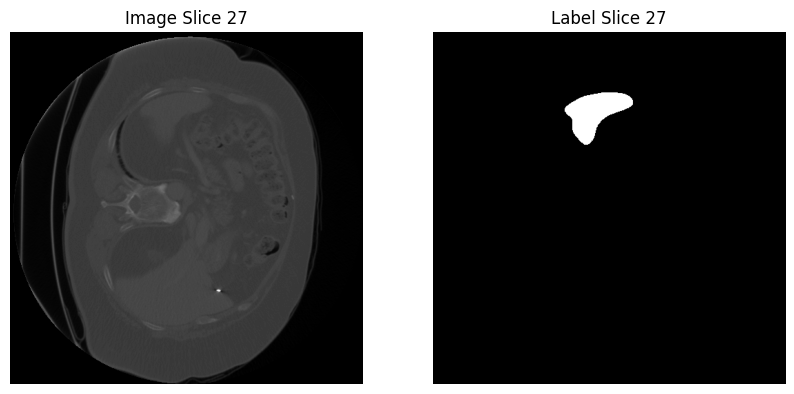

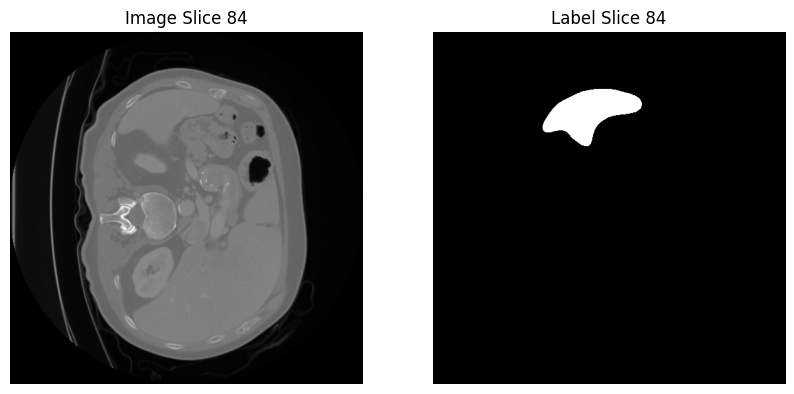

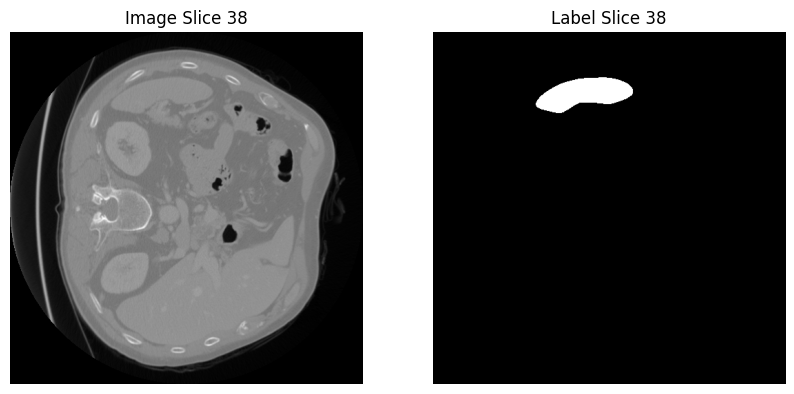

In [23]:
def visualize_image_and_label(image_path, label_path, slice_index=None):
    image = nib.load(image_path).get_fdata()
    label = nib.load(label_path).get_fdata()
    
    if slice_index is None:
        slice_index = image.shape[2] // 2
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(image[:, :, slice_index], cmap='gray')
    axes[0].set_title(f"Image Slice {slice_index}")
    axes[0].axis('off')
    
    axes[1].imshow(label[:, :, slice_index], cmap='gray')
    axes[1].set_title(f"Label Slice {slice_index}")
    axes[1].axis('off')
    
    plt.show()

visualize_image_and_label(os.path.join(train_dir, train_images[0]), os.path.join(label_dir, train_labels[0]))
visualize_image_and_label(os.path.join(train_dir, train_images[1]), os.path.join(label_dir, train_labels[1]))
visualize_image_and_label(os.path.join(train_dir, train_images[2]), os.path.join(label_dir, train_labels[2]))


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os
import numpy as np
import torch
import glob
import tempfile
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from monai.utils import set_determinism
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    RandCropByPosNegLabeld,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import CacheDataset

set_determinism(seed=0)


Loading dataset: 100%|██████████| 9/9 [00:04<00:00,  2.07it/s]

----------
epoch 1/5


1/16, train_loss: 0.6759
2/16, train_loss: 0.6818
3/16, train_loss: 0.6704
4/16, train_loss: 0.6902
5/16, train_loss: 0.6713
6/16, train_loss: 0.6767
7/16, train_loss: 0.7036
8/16, train_loss: 0.6580
9/16, train_loss: 0.6539
10/16, train_loss: 0.6229
11/16, train_loss: 0.6379
12/16, train_loss: 0.6652
13/16, train_loss: 0.6104
14/16, train_loss: 0.6936
15/16, train_loss: 0.6338
16/16, train_loss: 0.6166
epoch 1 average loss: 0.6601
saved new best metric model
current epoch: 1 current mean dice: 0.1204
best mean dice: 0.1204 at epoch: 1
----------
epoch 2/5
1/16, train_loss: 0.6558
2/16, train_loss: 0.6417
3/16, train_loss: 0.6609
4/16, train_loss: 0.6451
5/16, train_loss: 0.6604
6/16, train_loss: 0.6544
7/16, train_loss: 0.6178
8/16, train_loss: 0.6338
9/16, train_loss: 0.6628
10/16, train_loss: 0.6292
11/16, train_loss: 0.6106
12/16, train_loss: 0.6038
13/16, train_loss: 0.6328
14/16, train_loss: 0.6110
15/16, train_loss: 0.6193
16/16, train_loss: 0.6391
epoch 2 average loss: 0.6362
c

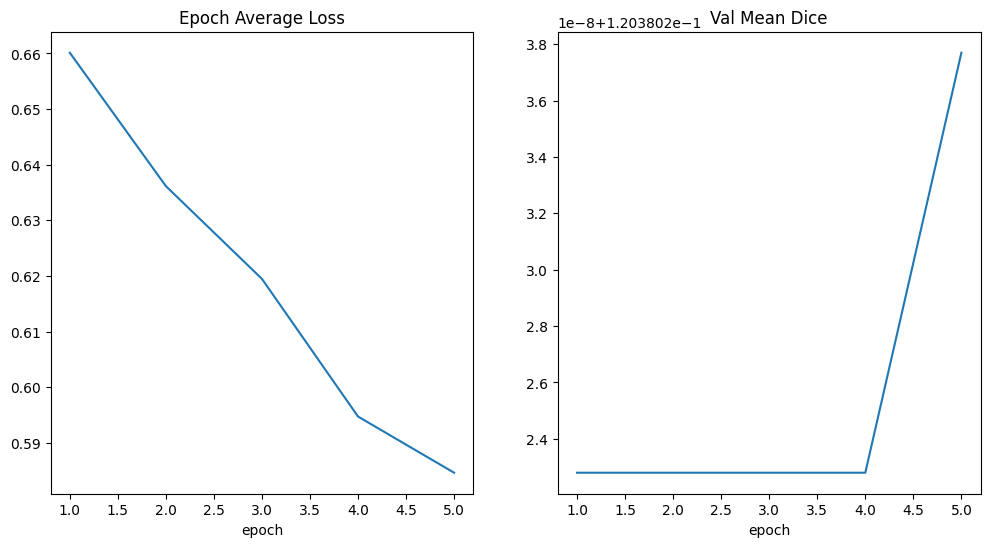

In [32]:
train_dir = './train'
label_dir = './train/labels'

train_images = sorted(glob.glob(os.path.join(train_dir, "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)


train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

max_epochs = 5  
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        
        if isinstance(batch_data, list):
            inputs = batch_data[0]["image"].to(device)
            labels = batch_data[0]["label"].to(device)
        else:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                if isinstance(val_data, list):
                    val_inputs = val_data[0]["image"].to(device)
                    val_labels = val_data[0]["label"].to(device)
                else:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)

                val_outputs = model(val_inputs)
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()
